
## TTS. 

Будем работать с моделью **XTTS v2** (2024) из статьи [XTTS: a Massively Multilingual Zero-Shot Text-to-Speech Model](https://arxiv.org/abs/2406.04904).

**github**: https://github.com/coqui-ai/TTS

**demo**: https://edresson.github.io/XTTS/

- работает с **16 языками**

- LM-based

- Дискретное представление - **VQ-токены**

- основана на модели [Tortoise](https://arxiv.org/pdf/2305.07243), улучшена для multi-lingual режима





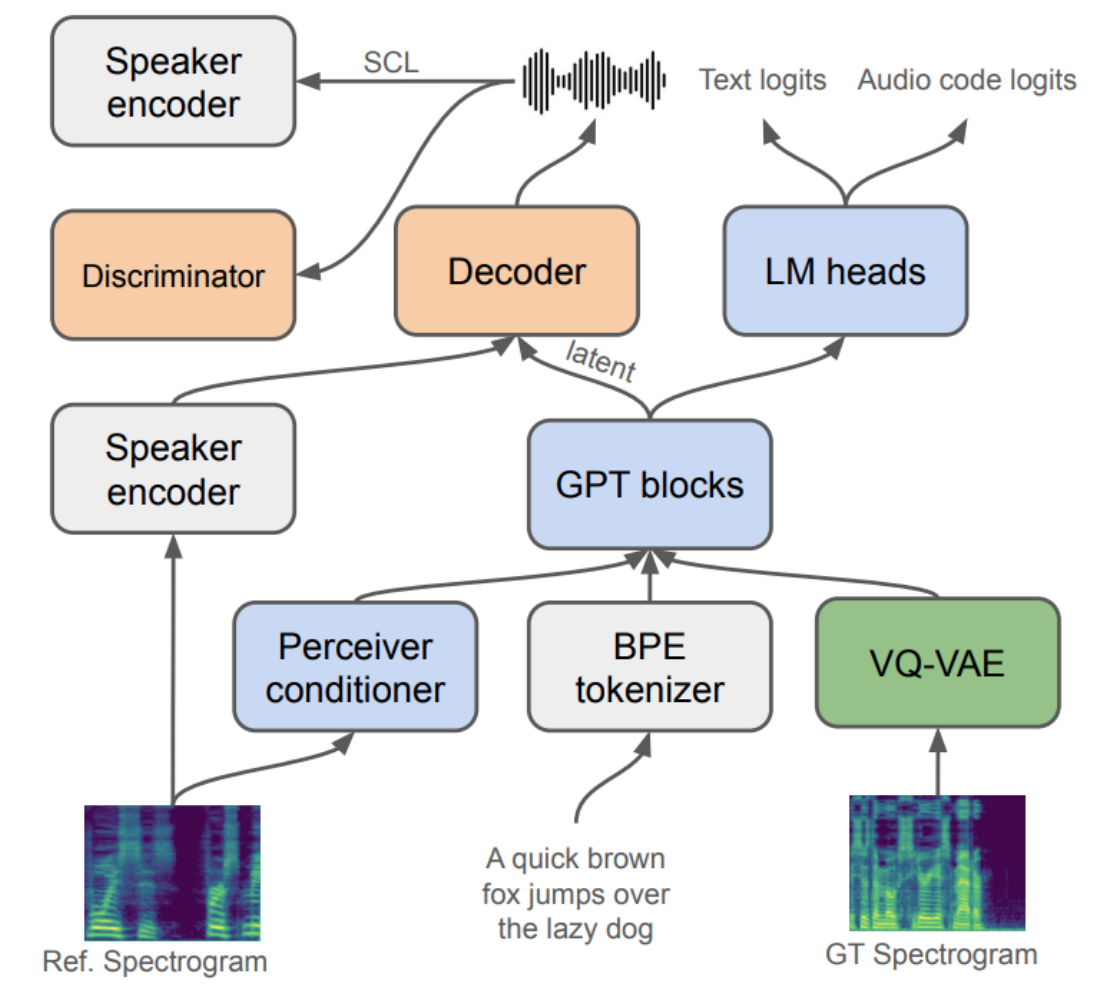

In [ ]:
from IPython.display import display, Image
Image('imgs/xtts.png', width=500)

# VQ-VAE

- 13M параметров

- 1 кодбук с частотй 21.53 Hz и размером словаря 8192

- **Новая идея**: сохранение из всех кодов словаря только 1024 наиболее частотных. Улучшает экспрессивность.

# Encoder

- decoder only Transformer

- инициализируется GPT-2

- 443M паарметров

- принимает на вход текст (BPE tokenizer)

- LM-heads на предсказание текста

**Обуславливание на голос**

- эмбеддинг стиля/голоса - **32** эбмеддинга размерности 1024

- 32 эмбеддинга позволяют сохранить способность клонирования голоса в мультязычном сценарии (одного было недостаточно)

- "16-head Scaled Dot-Product Attention layers followed by a Perceiver Resampler". Perceiver Resampler -- модуль, который позволяет сжимать данные переменной длины в фиксированное количество признаков (предложен в модели Flamingo). выучивает 32 датентных вектора, итоговые признаки для конкретного аудио считаются с помощью клосс-аттеншена

# Decoder

- HiFi-GAN вокодер

- учится на латентных векторах GPT-2 вместо дискретных токенов, так как при обучении на них появлялись артефакты

- 26М параметров

- добавляется speaker embedding из предобученной модели H/ASP в каждый слой upsampling

- в лосс добавляется speaker consistency loss (SCL)

- восстанавливает аудио с частотой дискретизации 24kHz

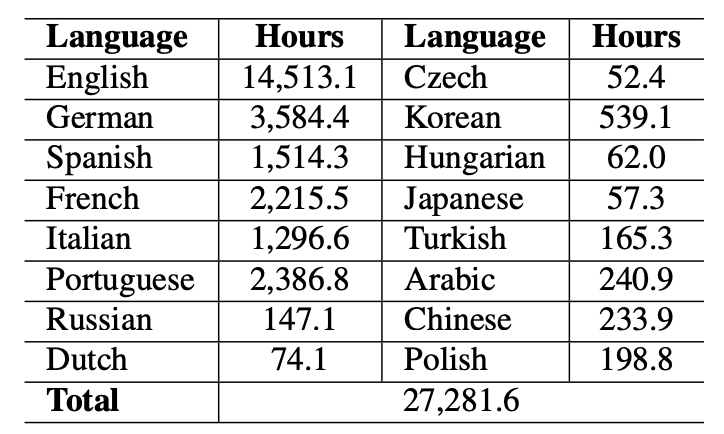

In [ ]:
Image('imgs/xtts_languages.png', width=500)

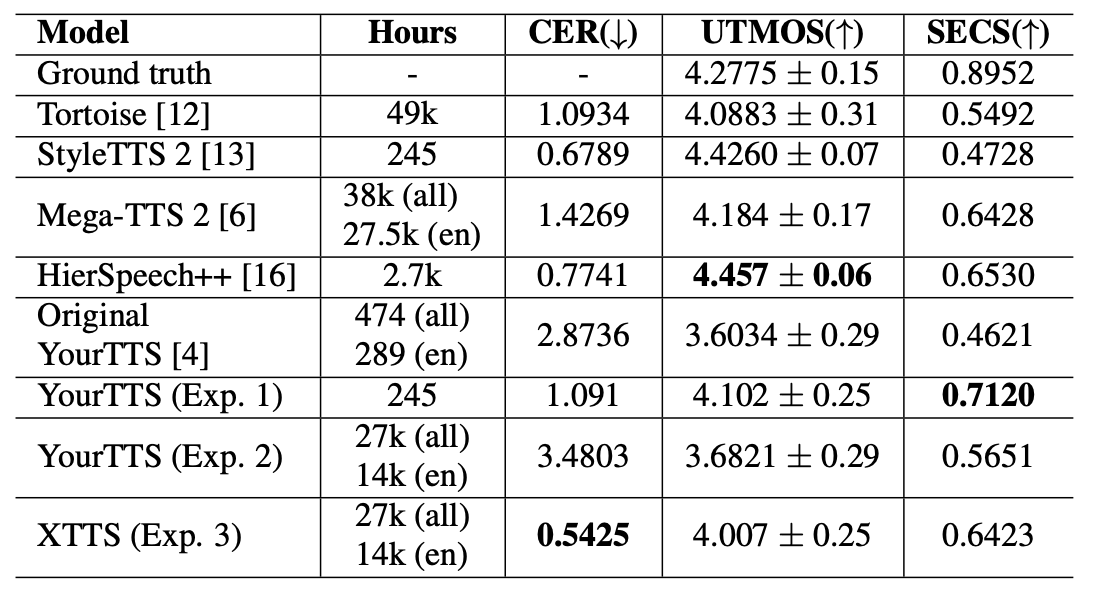

In [ ]:
Image('imgs/metrics.png', width=500)

# Zero-shot TTS

**Документация**: https://docs.coqui.ai/en/dev/models/xtts.html

In [ ]:
import os
from IPython.display import Audio, display

# загрузка модели
from TTS.api import TTS
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=False)

 > tts_models/multilingual/multi-dataset/xtts_v2 is already downloaded.
/Users/tasnima/Library/Application Support/tts/tts_models--multilingual--multi-dataset--xtts_v2
 > Using model: xtts


In [ ]:
en_sentences = [
    "For a full hour he had paced up and down, waiting: but he could wait no longer.",
    "Our mouths open, our lips move, but not a word can be heard.",
    "For a long time he had wished to explore the beautiful Land of Oz in which they lived."
]

ru_sentences = [
    'Приплыла к нему рыбка, спросила: "Чего тебе надобно, старче?"',
    'Он ехал день, другой и третий — вдруг вышел ему навстречу пребольшой серый волк и сказал',
    'Обрадовались старики, привели ее в избу.'
]

out_dir = 'generated_samples/'
!mkdir $out_dir

mkdir: generated_samples/: File exists


In [ ]:
ref_wavs_dir = '/Users/tasnima/Documents/dls/lectures/dls_seminar2/reference_samples/'
[f for f in os.listdir(ref_wavs_dir) if f.endswith('.wav')]

['smaug_2.wav',
 'librispeech_female.wav',
 'librispeech_male.wav',
 'smaug_1.wav',
 'fearful.wav',
 'meryl.wav',
 'lj.wav',
 'librispeech_female_3.wav',
 'librispeech_female_2.wav',
 'librispeech_male_3.wav',
 'librispeech_male_2.wav',
 'angry.wav']

In [ ]:
reference_wav = os.path.join(ref_wavs_dir, 'smaug_1.wav')
lang = 'en'

In [ ]:
print('Reference audio:')
display(Audio(reference_wav))

for i in range(2):
  out_file = f'{out_dir}/{i}_{lang}.wav'
  tts.tts_to_file(text=en_sentences[i],
                  file_path=out_file,
                  # speaker=,
                  speaker_wav=reference_wav,
                  language=lang,
                  split_sentences=True
                  )
  display(Audio(out_file))


Reference audio:


 > Text splitted to sentences.
['For a full hour he had paced up and down, waiting: but he could wait no longer.']
 > Processing time: 14.143931150436401
 > Real-time factor: 1.0723499541560855


 > Text splitted to sentences.
['Our mouths open, our lips move, but not a word can be heard.']
 > Processing time: 7.089115858078003
 > Real-time factor: 1.0108316391012673


In [ ]:
lang = 'ru'
for i in range(2):
  out_file = f'{out_dir}/{i}_{lang}.wav'
  tts.tts_to_file(text=ru_sentences[i],
                  file_path=out_file,
                  # speaker=,
                  speaker_wav=reference_wav,
                  language=lang,
                  split_sentences=True
                  )
  display(Audio(out_file))

 > Text splitted to sentences.
['Приплыла к нему рыбка, спросила: "Чего тебе надобно, старче?"']
 > Processing time: 12.492532968521118
 > Real-time factor: 1.0705971019988287


 > Text splitted to sentences.
['Он ехал день, другой и третий — вдруг вышел ему навстречу пребольшой серый волк и сказал']
 > Processing time: 20.32740616798401
 > Real-time factor: 1.1465520658639121


# Объективные метрики

In [ ]:
import pandas as pd
test_sent = pd.read_csv('reference_samples/eval_sentences10.tsv', sep="\t", header=None)
test_sent[:10]

0  \
0  121_127105_000043_000004   
1  121_127105_000040_000000   
2  121_127105_000012_000001   
3  121_127105_000016_000002   
4  121_127105_000008_000000   
5  121_121726_000025_000001   
6  121_127105_000018_000001   
7  121_127105_000014_000000   
8  121_127105_000008_000002   
9  121_121726_000034_000001   

                                                   1  \
0  He was handsome and bold and pleasant, offhand...   
1                        With this outbreak at last.   
2  He passed his hand over his eyes, made a littl...   
3  I shall have to send to town." There was a una...   
4  I quite agree--in regard to Griffin's ghost, o...   
5  Once held by Hobson and Dewey, now carried by ...   
6  I took that HERE"--he tapped his heart. "I've ...   
7  He took no notice of her; he looked at me, but...   
8  If the child gives the effect another turn of ...   
9  Also, a draft on futurity, sometimes honored, ...   

                                                   2  
0  He was handsome and bold and pleasant, offhand...  
1                        With this outbreak at last.  
2  He passed his hand over his eyes, made a littl...  
3  I shall have to send to town." There was a una...  
4                                                NaN  
5  Once held by Hobson and Dewey, now carried by ...  
6  I took that HERE"--he tapped his heart. "I've ...  
7  He took no notice of her; he looked at me, but...  
8  If the child gives the effect another turn of ...  
9  Also, a draft on futurity, sometimes honored, ...

In [ ]:
out_dir_sim_test = os.path.join(out_dir, 'sim_test')
os.makedirs(out_dir_sim_test, exist_ok=True)

In [ ]:
list(test_sent[2].values[:4]) + list(test_sent[2].values[6:10]) + list(test_sent[2].values[12:14])

['He was handsome and bold and pleasant, offhand and gay and kind.',
 'With this outbreak at last.',
 'He passed his hand over his eyes, made a little wincing grimace.',
 'I shall have to send to town." There was a unanimous groan at this, and much reproach; after which, in his preoccupied way, he explained.',
 'I took that HERE"--he tapped his heart. "I\'ve never lost it."',
 'He took no notice of her; he looked at me, but as if, instead of me, he saw what he spoke of.',
 'If the child gives the effect another turn of the screw, what do you say to TWO children-?"',
 'Also, a draft on futurity, sometimes honored, but generally extended.',
 'Marie clasped her hands and started up from her seat.',
 'The old people in the mountains plant lindens to purify the forest, and to do away with the spells that come from the old trees they say have lasted from heathen times.']

In [ ]:
test_sent[2].values[20:25]

array(['The roarings become lost in the distance.', nan,
       'But, I remarked, "since we have followed the road that Saknussemm has shown us-"',
       'My uncle notices it, and looks on approvingly.',
       'Two hours afterwards a terrible shock awoke me.'], dtype=object)

In [ ]:
sentences = list(test_sent[2].values[:4]) + list(test_sent[2].values[6:10]) + list(test_sent[2].values[12:14])
reference_wav = os.path.join(ref_wavs_dir, 'librispeech_female.wav')
lang='en'

for i,sent in enumerate(sentences):
    out_file = f'{out_dir_sim_test}/{i}_female.wav'
    tts.tts_to_file(text=sentences[i],
                   file_path=out_file,
                   speaker_wav=reference_wav,
                   language=lang,
                   split_sentences=True
                   )

 > Text splitted to sentences.
['He was handsome and bold and pleasant, offhand and gay and kind.']
 > Processing time: 6.012603998184204
 > Real-time factor: 1.2816890773391503
 > Text splitted to sentences.
['With this outbreak at last.']
 > Processing time: 3.612546682357788
 > Real-time factor: 1.010050902135185
 > Text splitted to sentences.
['He passed his hand over his eyes, made a little wincing grimace.']
 > Processing time: 5.709156036376953
 > Real-time factor: 1.0373013398328264
 > Text splitted to sentences.
['I shall have to send to town.', '" There was a unanimous groan at this, and much reproach; after which, in his preoccupied way, he explained.']
 > Processing time: 10.53375792503357
 > Real-time factor: 1.071036973619366
 > Text splitted to sentences.
['I took that HERE"--he tapped his heart. "I\'ve never lost it.', '"']
 > Processing time: 6.407938718795776
 > Real-time factor: 0.9075992340020996
 > Text splitted to sentences.
['He took no notice of her; he looked a

In [ ]:
# sentences = test_sent[2].values[5:15]
reference_wav = os.path.join(ref_wavs_dir, 'librispeech_male.wav')
lang='en'

for i,sent in enumerate(sentences):
    out_file = f'{out_dir_sim_test}/{i}_male.wav'
    tts.tts_to_file(text=sentences[i],
                   file_path=out_file,
                   speaker_wav=reference_wav,
                   language=lang,
                   split_sentences=True
                   )

 > Text splitted to sentences.
['He was handsome and bold and pleasant, offhand and gay and kind.']
 > Processing time: 6.2552618980407715
 > Real-time factor: 1.0241811575665247
 > Text splitted to sentences.
['With this outbreak at last.']
 > Processing time: 3.39300799369812
 > Real-time factor: 0.8722233055988102
 > Text splitted to sentences.
['He passed his hand over his eyes, made a little wincing grimace.']
 > Processing time: 4.987657308578491
 > Real-time factor: 0.9139230459227141
 > Text splitted to sentences.
['I shall have to send to town.', '" There was a unanimous groan at this, and much reproach; after which, in his preoccupied way, he explained.']
 > Processing time: 10.41829800605774
 > Real-time factor: 0.9555248861705259
 > Text splitted to sentences.
['I took that HERE"--he tapped his heart. "I\'ve never lost it.', '"']
 > Processing time: 7.509792804718018
 > Real-time factor: 0.9305370624889424
 > Text splitted to sentences.
['He took no notice of her; he looked

## Speaker similarity

Модель [WavLM-sv](https://huggingface.co/microsoft/wavlm-base-sv)

- The model was pretrained on 16kHz sampled speech audio with utterance and speaker contrastive loss.

- The model is fine-tuned on the VoxCeleb1 dataset using an X-Vector head

- The model was pre-trained on 960h of Librispeech.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor, WavLMForXVector
from datasets import load_dataset
import torch
import torchaudio

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('microsoft/wavlm-base-sv')
model = WavLMForXVector.from_pretrained('microsoft/wavlm-base-sv')

/Users/tasnima/Documents/dls/project_dubbing/XTTS/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/wavlm-base-sv were not used when initializing WavLMForXVector: ['wavlm.encoder.pos_conv_embed.conv.weight_g', 'wavlm.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
So

In [ ]:
a, sr = torchaudio.load('/Users/tasnima/Documents/dls/lectures/dls_seminar2/reference_samples/lj.wav')
if sr != 16000:
    resample_rate = 16000
    resampler = torchaudio.transforms.Resample(sr, resample_rate, dtype=a.dtype)
    resampled_waveform = resampler(a)
    a = resampled_waveform

In [ ]:
a, sr = torchaudio.load('/Users/tasnima/Documents/dls/lectures/dls_seminar2/reference_samples/librispeech_male.wav')
if sr != 16000:
    resample_rate = 16000
    resampler = torchaudio.transforms.Resample(sr, resample_rate, dtype=a.dtype)
    resampled_waveform = resampler(a)
    a = resampled_waveform

In [ ]:
# audio files are decoded on the fly
inputs = feature_extractor(a[0], sampling_rate=16000, return_tensors="pt")
embeddings = model(**inputs).embeddings
embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
embeddings.shape

/Users/tasnima/Documents/dls/project_dubbing/XTTS/.venv/lib/python3.9/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


torch.Size([1, 512])

In [ ]:
# audio files are decoded on the fly
inputs = feature_extractor(a[0], sampling_rate=16000, return_tensors="pt")
embeddings2 = model(**inputs).embeddings
embeddings2 = torch.nn.functional.normalize(embeddings2, dim=-1).cpu()
embeddings2.shape

/Users/tasnima/Documents/dls/project_dubbing/XTTS/.venv/lib/python3.9/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


torch.Size([1, 512])

In [ ]:
# the resulting embeddings can be used for cosine similarity-based retrieval
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
similarity = cosine_sim(embeddings[0], embeddings2[0])
print(f"Similarity score = {similarity:.2f}")
threshold = 0.86  # the optimal threshold is dataset-dependent
if similarity < threshold:
    print("Speakers are not the same!")

Similarity score = 0.78
Speakers are not the same!


In [ ]:
def load_audio(audio_path):
    a, sr = torchaudio.load(audio_path)
    if sr != 16000:
        resample_rate = 16000
        resampler = torchaudio.transforms.Resample(sr, resample_rate, dtype=a.dtype)
        resampled_waveform = resampler(a)
        a = resampled_waveform
    return a

def extract_embedding(audio_path):
    audio = load_audio(audio_path)
    inputs = feature_extractor(audio[0], sampling_rate=16000, return_tensors="pt")
    embeddings = model(**inputs).embeddings
    embeddings = torch.nn.functional.normalize(embeddings, dim=-1).cpu()
    return embeddings[0]

def cosine_similarity(emb1, emb2):
    cosine_sim = torch.nn.CosineSimilarity(dim=-1)
    similarity = cosine_sim(emb1, emb2)
    return similarity

In [ ]:
emb1 = extract_embedding(os.path.join(ref_wavs_dir, 'librispeech_female.wav'))
emb2 = extract_embedding(os.path.join(ref_wavs_dir, 'librispeech_female_2.wav'))
emb3 = extract_embedding(os.path.join(ref_wavs_dir, 'librispeech_female_3.wav'))

emb4 = extract_embedding(os.path.join(ref_wavs_dir, 'librispeech_male.wav'))
emb5 = extract_embedding(os.path.join(ref_wavs_dir, 'librispeech_male_2.wav'))
emb6 = extract_embedding(os.path.join(ref_wavs_dir, 'librispeech_male_3.wav'))

/Users/tasnima/Documents/dls/project_dubbing/XTTS/.venv/lib/python3.9/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
print(cosine_similarity(emb1, emb2))
print(cosine_similarity(emb1, emb3))
print(cosine_similarity(emb3, emb2))


print(cosine_similarity(emb4, emb5))
print(cosine_similarity(emb4, emb6))
print(cosine_similarity(emb5, emb6))

tensor(0.9424, grad_fn=<SumBackward1>)
tensor(0.9180, grad_fn=<SumBackward1>)
tensor(0.9634, grad_fn=<SumBackward1>)
tensor(0.9073, grad_fn=<SumBackward1>)
tensor(0.9541, grad_fn=<SumBackward1>)
tensor(0.8913, grad_fn=<SumBackward1>)


In [ ]:
import numpy as np
ref_wav_path = os.path.join(ref_wavs_dir, 'librispeech_female.wav')
emb_ref = extract_embedding(ref_wav_path)

sims = []
for audio_file in [f'{out_dir_sim_test}/{i}_female.wav' for i in range(10)]:
    emb = extract_embedding(audio_file).detach()
    sims.append(np.round(cosine_similarity(emb_ref, emb).detach().numpy(),2))
print(np.mean(sims), sims)


/Users/tasnima/Documents/dls/project_dubbing/XTTS/.venv/lib/python3.9/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


0.9480001 [0.95, 0.86, 0.95, 0.96, 0.96, 0.94, 0.98, 0.96, 0.95, 0.97]


In [ ]:
ref_wav_path = os.path.join(ref_wavs_dir, 'librispeech_male.wav')
emb_ref = extract_embedding(ref_wav_path)

sims = []
for audio_file in [f'{out_dir_sim_test}/{i}_male.wav' for i in range(10)]:
    emb = extract_embedding(audio_file).detach()
    sims.append(np.round(cosine_similarity(emb_ref, emb).detach().numpy(),2))
print(np.mean(sims), sims)

0.886 [0.85, 0.9, 0.89, 0.9, 0.87, 0.91, 0.92, 0.9, 0.84, 0.88]
